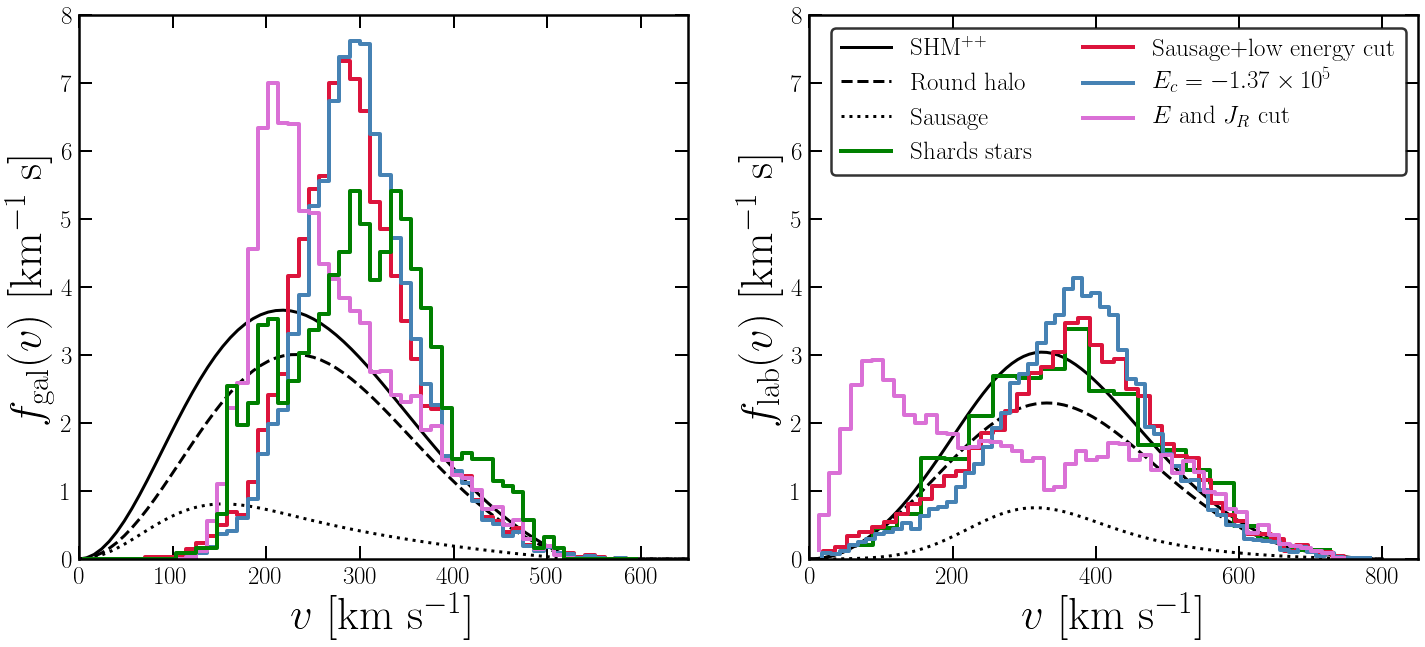

In [6]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas
import cmocean
from copy import copy

df = pandas.read_csv('../data/Gaia-SDSS.csv')
df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df_S.group_id.unique()


# Fit
means_init = zeros(shape=(2,4))
means_init[0,:] = array([0.0,0.0,0.0,-1.4]) # Sausage
means_init[1,:] = array([0.0,0.0,0.0,-1.95]) # Halo
covariance_type = 'full'
data = array([df.GalRVel,df.GalphiVel,df.GalzVel,df.feh]).T
clf = mixture.GaussianMixture(n_components=2, covariance_type=covariance_type,means_init=means_init)
clf.fit(data)

Ps = clf.predict_proba(data)
saus_mask = Ps[:,1]<Ps[:,0]
df1 = df.loc[~(Ps[:,0]>0.75)&(df['E'] > -1.41e5)]
df2 = df.loc[(df['E'] > -1.37e5)]
df3 = df.loc[(df.E/1.0e5)>((df.JR/5000)**(1.0/3.0)-1.8)]

method1 = r'Sausage+low energy cut'
method2 = r'$E_c=-1.37\times10^5$'
method3 = r'$E$ and $J_R$ cut'

# Analytic distributions
v = linspace(0,800.0,100)
day = 67
v_lab = LabVelocitySimple(day)
eta = 0.2
SCO = True
v0 = SHMpp.RotationSpeed
v_esc = SHMpp.EscapeSpeed
sig_beta = SHMpp.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
fv_Iso_lab = SpeedDist_Triaxial(v,67,sig_iso,SmoothCutoff=SCO) # Galactic frame Halo
fv_Saus_lab = SpeedDist_Triaxial(v,67,sig_beta,SmoothCutoff=SCO) # Galactic frame Sausage
fv_Iso_gal = SpeedDist_Triaxial(v,67,sig_iso,SmoothCutoff=SCO,GalFrame=True) # Galactic frame Halo
fv_Saus_gal = SpeedDist_Triaxial(v,67,sig_beta,SmoothCutoff=SCO,GalFrame=True) # Galactic frame Sausage
fv0_lab = (1-eta)*fv_Iso_lab + eta*fv_Saus_lab
fv0_gal = (1-eta)*fv_Iso_gal + eta*fv_Saus_gal


# Speeds
def speeds_Gal(dfc):
    return sqrt((dfc.GalRVel)**2.0+(dfc.GalphiVel)**2.0+(dfc.GalzVel)**2.0)

def speeds_Lab(dfc):
    return sqrt((dfc.GalRVel-v_lab[0])**2.0+(dfc.GalphiVel-v_lab[1])**2.0+(dfc.GalzVel-v_lab[2])**2.0)

vvS_lab = sqrt((df_S.GalRVel-v_lab[0])**2.0+(df_S.GalTVel-v_lab[1])**2.0+(df_S.GalzVel-v_lab[2])**2.0)
vvS_gal = sqrt((df_S.GalRVel)**2.0+(df_S.GalTVel)**2.0+(df_S.GalzVel)**2.0)


xlab1 = r"$v$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v)$ [km$^{-1}$ s]"
ylab2 = r"$f_{\rm lab}(v)$ [km$^{-1}$ s]"
fig,ax1,ax2 = MyDoublePlot(xlab1,ylab1,xlab1,ylab2,size_x=24,size_y=10,wspace=0.2)

nbins = 55
vmin = 0.0
vmax_lab = 800
vmax_gal = 600

alph = 0.5
col1 = 'crimson'
col2 = 'steelblue'
col3 = 'orchid'
colS = 'green'


# Galactic frame
ax1.plot(v,1e3*fv0_gal,'k-',lw=3,label=r'SHM$^{++}$')
ax1.plot(v,1e3*(1-eta)*fv_Iso_gal,'k--',lw=3,label='Round halo')
ax1.plot(v,1e3*eta*fv_Saus_gal,'k:',lw=3,label='Sausage')
h_shards,vbins = histogram(vvS_gal,bins=nbins,normed=True,range=(vmin,vmax_gal))
vc = (vbins[1:]+vbins[0:-1])/2

h1,_ = histogram(speeds_Gal(df1),bins=nbins,normed=True,range=(vmin,vmax_gal))
h2,_ = histogram(speeds_Gal(df2),bins=nbins,normed=True,range=(vmin,vmax_gal))
h3,_ = histogram(speeds_Gal(df3),bins=nbins,normed=True,range=(vmin,vmax_gal))

#ax1.fill_between(vc,1e3*h1,y2=0,color=col1,lw=None,alpha=alph,step='pre',zorder=0,label=method1)
ax1.step(vc,1e3*h1,'-',color=col1,lw=4,label=method1)

#ax1.fill_between(vc,1e3*h2,y2=0,color=col2,lw=None,alpha=alph,step='pre',zorder=0,label=method2)
ax1.step(vc,1e3*h2,'-',color=col2,lw=4,label=method2)

#ax1.fill_between(vc,1e3*h3,y2=0,color=col3,lw=None,alpha=alph,step='pre',zorder=0,label=method3)
ax1.step(vc,1e3*h3,'-',color=col3,lw=4,label=method3)

ax1.step(vc,1e3*h_shards,'-',color=colS,lw=4,label='Shards stars')



# Lab frame
ax2.plot(v,1e3*fv0_lab,'k-',lw=3,label=r'SHM$^{++}$')
ax2.plot(v,1e3*(1-eta)*fv_Iso_lab,'k--',lw=3,label='Round halo')
ax2.plot(v,1e3*eta*fv_Saus_lab,'k:',lw=3,label='Sausage')



h1,v1 = histogram(speeds_Lab(df1),bins='fd',normed=True)
h2,v2 = histogram(speeds_Lab(df2),bins='fd',normed=True)
h3,v3 = histogram(speeds_Lab(df3),bins=50,normed=True)

h_shards,vs = histogram(vvS_lab,bins='fd',normed=True)
ax2.step((vs[1:]+vs[0:-1])/2,1e3*h_shards,'-',color=colS,lw=4,label='Shards stars')

#ax2.fill_between(vc,1e3*h1,y2=0,color=col1,lw=None,alpha=alph,step='pre',zorder=0,label=method1)
ax2.step((v1[1:]+v1[0:-1])/2,1e3*h1,'-',color=col1,lw=4,label=method1)

#ax2.fill_between(vc,1e3*h2,y2=0,color=col2,lw=None,alpha=alph,step='pre',zorder=0,label=method2)
ax2.step((v2[1:]+v2[0:-1])/2,1e3*h2,'-',color=col2,lw=4,label=method2)

#ax2.fill_between(vc,1e3*h3,y2=0,color=col3,lw=None,alpha=alph,step='pre',zorder=0,label=method3)
ax2.step((v3[1:]+v3[0:-1])/2,1e3*h3,'-',color=col3,lw=4,label=method3)





# Legend lines
leg = ax2.legend(loc='upper right',fontsize=25,edgecolor='k',ncol=2)
leg.get_frame().set_linewidth(2.5)



# Limits
ax1.set_xlim([0,650])
ax1.set_ylim(bottom=0.0,top=8.)
ax2.set_xlim([0,850])
ax2.set_ylim(bottom=0.0,top=8.)


# Save
plt.show()
pltname = 'fvmethod_comparison'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')     

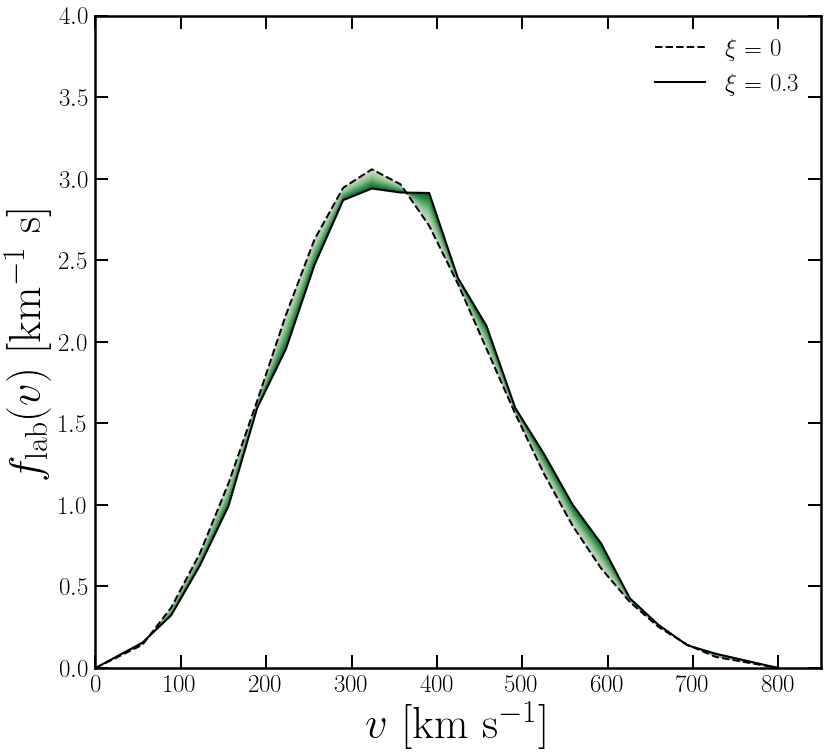

In [8]:
fig,ax1 = MySquarePlot(xlab1,ylab2)


xi_max = 0.3
n_xi = 10
xi_vals = linspace(0,xi_max,n_xi)
eta = 0.2

def fv0_Lab(h,vbins,xi):
    vc = (vbins[1:]+vbins[0:-1])/2.0
    fI = SpeedDist_Triaxial(vc,67,sig_iso,SmoothCutoff=SCO) # Galactic frame Halo
    fS = SpeedDist_Triaxial(vc,67,sig_beta,SmoothCutoff=SCO) # Galactic frame Sausage
    fv0 = (1-xi)*((1-eta)*fI + eta*fS)+xi*h
    fv0 = append(append(0.0,fv0),0.0)
    return fv0

alph = 0.8

def plotfvrange(vv,cmap):
    h,vs = histogram(vv,bins='fd',normed=True)
    vc = append(append(0.0,(vs[1:]+vs[0:-1])/2),vmax_lab)
    y2 = 1e3*fv0_Lab(h,vs,0.0)
    cols = flipud(cmap(linspace(0,1,n_xi)))
    for i in range(0,n_xi):
        y1 = 1e3*fv0_Lab(h,vs,xi_vals[n_xi-i-1])
        ax1.fill_between(vc,y1,y2=y2,alpha=alph,facecolor=cols[i,:],edgecolor=None)
        y2 = y1
    ax1.plot(vc,1e3*fv0_Lab(h,vs,0.0),'--',color='k',lw=2,label=r'$\xi$ = 0')
    ax1.plot(vc,1e3*fv0_Lab(h,vs,xi_max),color='k',lw=2,label=r'$\xi$ = 0.3')
    return y2

pltname = 'fvcomb_shards'
y2 = plotfvrange(vvS_lab,cm.Greens)

# pltname = 'fvcomb_sausagecut'
# y2 = plotfvrange(speeds_Lab(df1),cm.Reds)

# pltname = 'fvcomb_energycut'
# y2 = plotfvrange(speeds_Lab(df2),cm.Blues)

# pltname = 'fvcomb_actioncut'
# y2 = plotfvrange(speeds_Lab(df3),cm.Purples)

# Legend lines
leg = ax1.legend(loc='upper right',fontsize=25,edgecolor='k',ncol=1,frameon=False)
leg.get_frame().set_linewidth(2.5)


ax1.set_xlim([0,850])
ax1.set_ylim(bottom=0.0,top=4.)


# Save
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

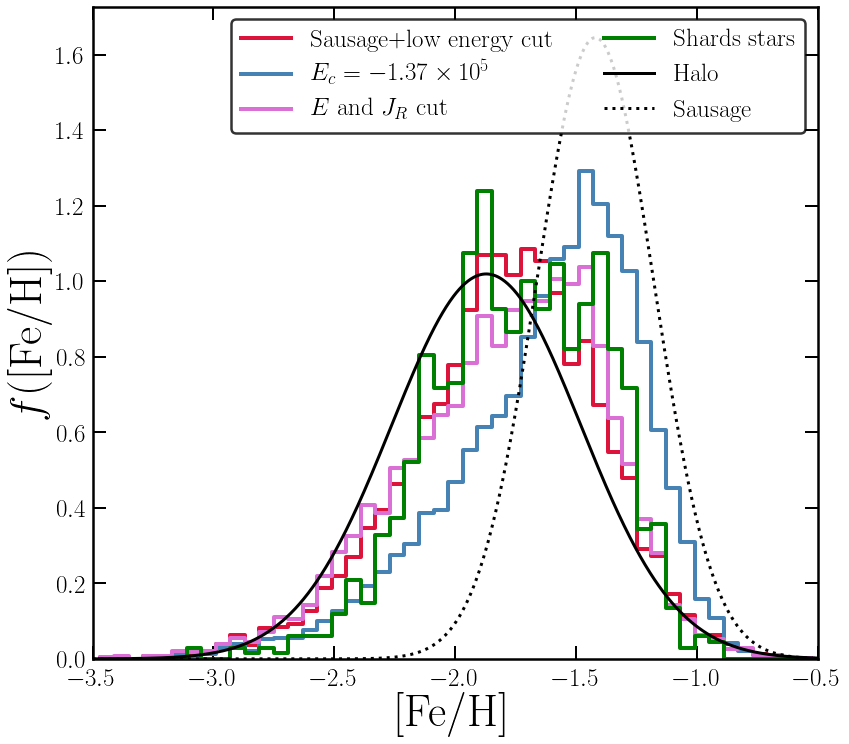

In [9]:
xlab1 = r"[Fe/H]"
ylab1 = r"$f([$Fe/H$])$"
fig,ax1 = MySquarePlot(xlab1,ylab1)

nbins = 50
feh_min = -3.5
feh_max = -0.5

h_shards,fehbins = histogram(df_S.feh,bins=nbins,normed=True,range=(feh_min,feh_max))
fehc = (fehbins[1:]+fehbins[0:-1])/2

h1,_ = histogram(df1.feh,bins=nbins,normed=True,range=(feh_min,feh_max))
h2,_ = histogram(df2.feh,bins=nbins,normed=True,range=(feh_min,feh_max))
h3,_ = histogram(df3.feh,bins=nbins,normed=True,range=(feh_min,feh_max))

ax1.step(fehc,h1,'-',color=col1,lw=4,label=method1)
ax1.step(fehc,h2,'-',color=col2,lw=4,label=method2)
ax1.step(fehc,h3,'-',color=col3,lw=4,label=method3)
ax1.step(fehc,h_shards,'-',color=colS,lw=4,label='Shards stars')



# Analytic models for metallicity
feh_fine = linspace(feh_min,feh_max,1000)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_
mu = meens[1,3]
sigsq = covs[1,3,3]
f1 = (1.0/sqrt(2*pi*sigsq))*exp(-(feh_fine-mu)**2.0/(2*sigsq))
f1 /= trapz(f1,feh_fine)

mu = meens[0,3]
sigsq = covs[0,3,3]
f0 = (1.0/sqrt(2*pi*sigsq))*exp(-(feh_fine-mu)**2.0/(2*sigsq))
f0 /= trapz(f0,feh_fine)

#plt.plot(feh_fine,ws[0]*f0+ws[1]*f1,'k-',lw=3,label='Total')
plt.plot(feh_fine,f1,'k-',lw=3,label=r'Halo')
plt.plot(feh_fine,f0,'k:',lw=3,label=r'Sausage')


# Legend lines
leg = ax1.legend(loc='upper right',fontsize=25,edgecolor='k',ncol=2)
leg.get_frame().set_linewidth(2.5)

ax1.set_ylim(bottom=0.0)
ax1.set_xlim([feh_min,feh_max])

# Save
plt.show()
pltname = 'ffeh_comparison'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

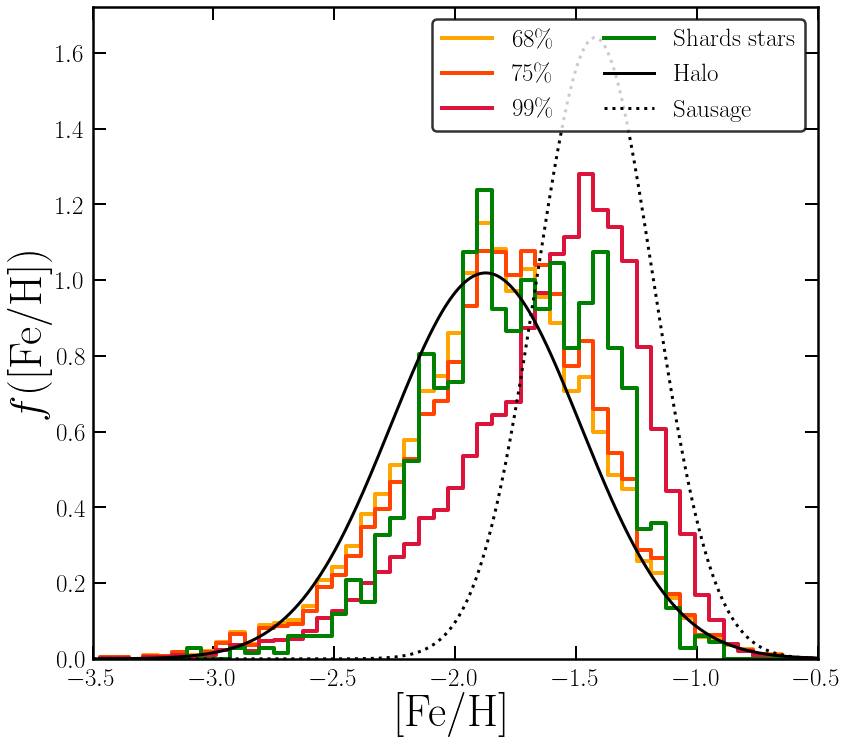

In [5]:
xlab1 = r"[Fe/H]"
ylab1 = r"$f([$Fe/H$])$"
fig,ax1 = MySquarePlot(xlab1,ylab1)

nbins = 50
feh_min = -3.5
feh_max = -0.5

h_shards,fehbins = histogram(df_S.feh,bins=nbins,normed=True,range=(feh_min,feh_max))
fehc = (fehbins[1:]+fehbins[0:-1])/2

cut1 = ~(Ps[:,0]>0.68)
cut2 = ~(Ps[:,0]>0.75)
cut3 = ~(Ps[:,0]>0.99)
dfc1 = df.loc[cut1&(df['E'] > -1.41e5)]
dfc2 = df.loc[cut2&(df['E'] > -1.41e5)]
dfc3 = df.loc[cut3&(df['E'] > -1.41e5)]

h1,_ = histogram(dfc1.feh,bins=nbins,normed=True,range=(feh_min,feh_max))
h2,_ = histogram(dfc2.feh,bins=nbins,normed=True,range=(feh_min,feh_max))
h3,_ = histogram(dfc3.feh,bins=nbins,normed=True,range=(feh_min,feh_max))

ax1.step(fehc,h1,'-',color='orange',lw=4,label='68\%')
ax1.step(fehc,h2,'-',color='orangered',lw=4,label='75\%')
ax1.step(fehc,h3,'-',color='crimson',lw=4,label='99\%')
ax1.step(fehc,h_shards,'-',color=colS,lw=4,label='Shards stars')



# Analytic models for metallicity
feh_fine = linspace(feh_min,feh_max,1000)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_
mu = meens[1,3]
sigsq = covs[1,3,3]
f1 = (1.0/sqrt(2*pi*sigsq))*exp(-(feh_fine-mu)**2.0/(2*sigsq))
f1 /= trapz(f1,feh_fine)

mu = meens[0,3]
sigsq = covs[0,3,3]
f0 = (1.0/sqrt(2*pi*sigsq))*exp(-(feh_fine-mu)**2.0/(2*sigsq))
f0 /= trapz(f0,feh_fine)

#plt.plot(feh_fine,ws[0]*f0+ws[1]*f1,'k-',lw=3,label='Total')
plt.plot(feh_fine,f1,'k-',lw=3,label=r'Halo')
plt.plot(feh_fine,f0,'k:',lw=3,label=r'Sausage')


# Legend lines
leg = ax1.legend(loc='upper right',fontsize=25,edgecolor='k',ncol=2)
leg.get_frame().set_linewidth(2.5)

ax1.set_ylim(bottom=0.0)
ax1.set_xlim([feh_min,feh_max])

# Save
plt.show()
pltname = 'ffeh_comparison_sausagecut'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

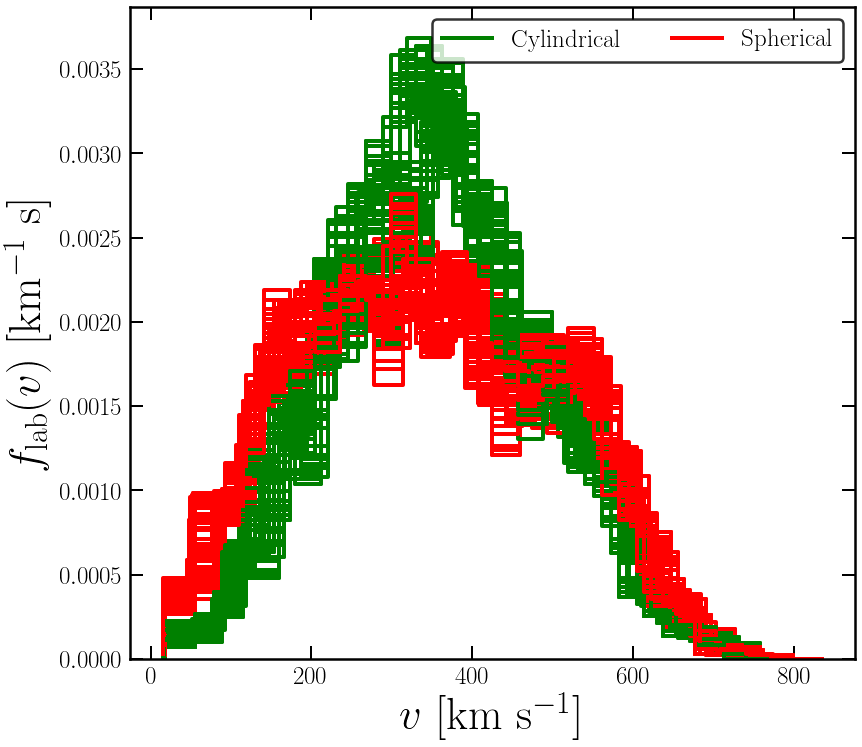

In [28]:

df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')


#df_S_in = pandas.read_csv('../data/Gaia-SDSS.csv')
#df_S = df_S_in.loc[df_S_in.helio_dist>4000.0]




x = df_S.GalRecX
y = df_S.GalRecY
z = df_S.GalRecZ
vx = df_S.GalU
vy = df_S.GalV
vz = df_S.GalW
R = sqrt(x**2.0+y**2.0+z**2.0)
th = arccos(z/R)
ph = arctan2(y,x)
vR_s = sin(th)*cos(ph)*vx + sin(th)*sin(ph)*vy + cos(ph)*vz
vth_S = cos(th)*cos(ph)*vx + cos(th)*sin(ph)*vy - sin(ph)*vz
vphi_S = -sin(ph)*vx + cos(ph)*vy
vrho_S = df_S.GalRVel
vz_S = df_S.GalzVel

xlab1 = r"$v$ [km s$^{-1}$]"
ylab2 = r"$f_{\rm lab}(v)$ [km$^{-1}$ s]"
fig,ax1 = MySquarePlot(xlab1,ylab2)

for day in linspace(0.0,365.0,100):
    v_lab = LabVelocitySimple(day)

    vvS_lab_cyl = sqrt((vrho_S-v_lab[0])**2.0+(vphi_S-v_lab[1])**2.0+(vz_S-v_lab[2])**2.0)
    vvS_lab_sph = sqrt((vR_s-v_lab[0])**2.0+(vphi_S-v_lab[1])**2.0+(vth_S-v_lab[2])**2.0)

    h_cyl,vb = histogram(vvS_lab_cyl,bins='fd',normed=True,range=(0.0,850.0))
    h_sph,_ = histogram(vvS_lab_sph,bins=vb,normed=True,range=(0.0,850.0))
    vc = (vb[1:]+vb[0:-1])/2

    ax1.step(vc,h_cyl,'-',color='green',lw=4)
    ax1.step(vc,h_sph,'-',color='red',lw=4)


ax1.step(vc,h_cyl,'-',color='green',lw=4,label='Cylindrical')
ax1.step(vc,h_sph,'-',color='red',lw=4,label='Spherical')


# Legend lines
leg = ax1.legend(loc='upper right',fontsize=25,edgecolor='k',ncol=2)
leg.get_frame().set_linewidth(2.5)

ax1.set_ylim(bottom=0.0)

# Save
plt.show()
#pltname = 'ffeh_comparison_sausagecut'
#fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
#fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')



In [18]:
df_S.columns

Index([u'Unnamed: 0', u'group_id', u'ra', u'dec', u'pmra_new', u'pmdec_new',
       u'phot_g_mean_mag', u'l', u'b', u'objid', u'psfmag_u', u'psfmagerr_u',
       u'psfmag_g', u'psfmagerr_g', u'psfmag_r', u'psfmagerr_r', u'psfmag_i',
       u'psfmagerr_i', u'psfmag_z', u'psfmagerr_z', u'extinction_u',
       u'extinction_g', u'extinction_r', u'extinction_i', u'extinction_z',
       u'hrv', u'hrv_e', u'logg', u'logg_e', u'teff', u'teff_e', u'feh',
       u'feh_e', u'helio_dist', u'X', u'Y', u'Z', u'GalR', u'Galphi', u'Galz',
       u'Galdist', u'GalRecX', u'GalRecY', u'GalRecZ', u'pml', u'pmb', u'U',
       u'V', u'W', u'GalU', u'GalV', u'GalW', u'GalRVel', u'GalTVel',
       u'GalzVel'],
      dtype='object')